# LSTM

## Importing libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,4)

import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error
from plotly.offline import init_notebook_mode, iplot

## Reading data

In [5]:
X_train = pd.read_csv('X_train.csv', index_col=['date'])
y_train = pd.read_csv('y_train.csv', index_col=['date'])

X_val = pd.read_csv('X_val.csv', index_col=['date'])
y_val = pd.read_csv('y_val.csv', index_col=['date'])

In [6]:
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)

In [7]:
BATCH_SIZE = 32
N_INPUT = len(X_train)
N_FEATURES = len(X_train.columns)

In [8]:
trace0 = go.Scatter(
    x = train_data.index,
    y = train_data['reference_evapotranspiration'],
    name = 'Train'
)

trace1 = go.Scatter(
    x = val_data.index,
    y = val_data['reference_evapotranspiration'],
    name = 'Validation'
)

data = [trace0, trace1]

iplot(data)

In [9]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [10]:
X, y = split_sequence(train_data['reference_evapotranspiration'].values, 5)

In [11]:
n_features = 1
n_steps = 5

In [12]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

model = Sequential()
model.add((LSTM(50,
                dropout=0.2,
                recurrent_dropout=0.2,
                activation='relu',
                input_shape=(n_steps, n_features))))
model.add(Dense(1))

model.compile(optimizer='adam', 
              loss='mean_absolute_error', 
              metrics=[mean_absolute_error, mean_squared_error])

In [13]:
model.fit(X, y, epochs=40, verbose=1)

Epoch 1/40
7/7 [==============================] - 3s 6ms/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 7.0450e-04
Epoch 2/40
7/7 [==============================] - 0s 6ms/step - loss: 0.0127 - mean_absolute_error: 0.0127 - mean_squared_error: 2.4410e-04
Epoch 3/40
7/7 [==============================] - 0s 7ms/step - loss: 0.0124 - mean_absolute_error: 0.0124 - mean_squared_error: 2.3603e-04
Epoch 4/40
7/7 [==============================] - 0s 5ms/step - loss: 0.0117 - mean_absolute_error: 0.0117 - mean_squared_error: 2.2805e-04
Epoch 5/40
7/7 [==============================] - 0s 5ms/step - loss: 0.0116 - mean_absolute_error: 0.0116 - mean_squared_error: 2.1275e-04
Epoch 6/40
7/7 [==============================] - 0s 5ms/step - loss: 0.0116 - mean_absolute_error: 0.0116 - mean_squared_error: 2.1354e-04
Epoch 7/40
7/7 [==============================] - 0s 6ms/step - loss: 0.0112 - mean_absolute_error: 0.0112 - mean_squared_error: 2.0716e-04
Epoch 8/40
7/7 [====

In [14]:
X_val, y_val = split_sequence(val_data['reference_evapotranspiration'].values, 5)

In [15]:
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

In [16]:
y_pred = model.predict(X_val, verbose=1)

2/2 [==============================] - 0s 5ms/step


In [17]:
y_pred = np.array([val for sublist in y_pred for val in sublist])

In [18]:
mae = mean_absolute_error(y_val, y_pred)
mae

<tf.Tensor: shape=(), dtype=float32, numpy=0.012039288>

In [20]:
mse = mean_squared_error(y_val, y_pred)
mse

<tf.Tensor: shape=(), dtype=float32, numpy=0.00020180189>

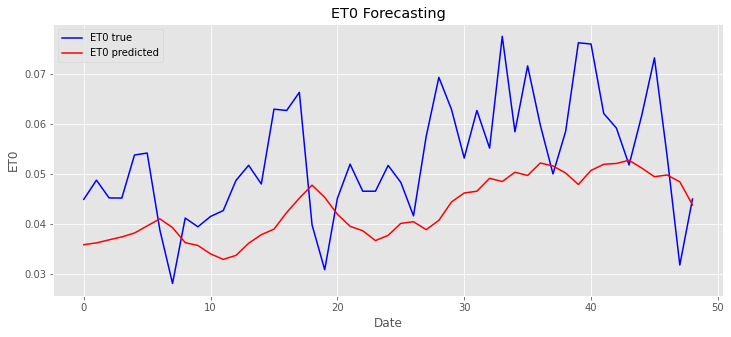

In [21]:
plt.figure(figsize=(12,5))  
plt.plot(y_val, color='blue', label='ET0 true')  
plt.plot(y_pred, color='red', label='ET0 predicted')  
plt.title('ET0 Forecasting')  
plt.xlabel('Date')  
plt.ylabel('ET0')  
plt.legend()
#plt.savefig("eto.png")
plt.show()

In [22]:
X_test = pd.read_csv('X_test.csv', index_col=['date'])
y_test = pd.read_csv('y_test.csv', index_col=['date'])

test_data = pd.concat([X_test, y_test], axis=1)

In [24]:
X_test, y_test = split_sequence(test_data['reference_evapotranspiration'].values, 5)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [25]:
y_pred_test = model.predict(X_test, verbose=1)

2/2 [==============================] - 0s 6ms/step


In [26]:
y_pred_test = np.array([val for sublist in y_pred_test for val in sublist])

In [27]:
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_test

<tf.Tensor: shape=(), dtype=float32, numpy=0.015868917>

In [28]:
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
rmse_test

0.01804758

* MAE = 0.015868917
* RMSE = 0.01804758